In [1]:
import pandas as pd
import pickle
import datetime
import time
import vitaldb
import numpy as np
import os

df_match = pd.read_csv('match_drug_arr_exclusion_20201110.csv',sep=',')
df_IDpath = pd.read_csv('opid_fileid.csv')
df_match['path']=[f_name.split('.')[0]+".csv" for f_name in df_match['path'].values.flatten()]

for j in range(len(df_IDpath)):
    #try: 
    #opid match
    idx_list = df_match[df_match['opid']==df_IDpath.loc[j,'opid']].index.tolist()
    i = min(idx_list)

    rec_path = 'preop_vital/preop_vital/' + df_IDpath.loc[j,'fileid']
    df_IDpath.loc[j, 'file_path'] = df_match.loc[i, 'path']
    df_IDpath.loc[j, 'NRS'] = df_match.loc[i, 'Value']
    df_IDpath.loc[j, 'NRS_time'] = df_match.loc[i, 'NRS_time']
#print(df_IDpath)

with open('../DL_model/caseid_test','rb') as f:
    test_list = pickle.load(f)

'''
caseid=[]
for fp in test_list:
    splits = fp.split(',')[2]
    caseid.append(splits)
'''
caseid = test_list.tolist()
print(caseid)
#print(len(caseid)) #787

['PACU1_10_190528_110437.csv', 'PACU1_10_190709_172441.csv', 'PACU1_10_190723_125732.csv', 'PACU1_10_190820_163322.csv', 'PACU1_10_190821_102951.csv', 'PACU1_10_190821_140008.csv', 'PACU1_10_190821_154935.csv', 'PACU1_10_190827_134744.csv', 'PACU1_10_190829_170015.csv', 'PACU1_10_190830_135223.csv', 'PACU1_10_200115_155300.csv', 'PACU1_10_200205_120438.csv', 'PACU1_10_200205_145216.csv', 'PACU1_10_200211_172517.csv', 'PACU1_10_200214_134908.csv', 'PACU1_10_200217_165735.csv', 'PACU1_10_200221_102154.csv', 'PACU1_10_200228_130016.csv', 'PACU1_10_200507_132540.csv', 'PACU1_10_200521_103234.csv', 'PACU1_10_200521_164846.csv', 'PACU1_10_200529_151443.csv', 'PACU1_10_200603_131444.csv', 'PACU1_10_200612_095554.csv', 'PACU1_10_200616_173958.csv', 'PACU1_10_200617_142506.csv', 'PACU1_10_200716_103518.csv', 'PACU1_10_200811_131641.csv', 'PACU1_10_200820_103206.csv', 'PACU1_10_200918_163449.csv', 'PACU1_10_200922_111940.csv', 'PACU1_10_201028_152639.csv', 'PACU1_11_190507_112917.csv', 'PACU1_11

# PreOp HR/MBP data

In [5]:
for i in range(len(df_IDpath)):
    if df_IDpath.loc[i,'file_path'] in caseid:
        rec_path = '../../cranberry2/Preprocessing/preop_vital/preop_vital/' + df_IDpath.loc[i,'fileid']
        HR = vitaldb.vital_recs(rec_path, ['Solar8000/HR'], interval = 0.01).flatten()[0:6000]
        MBP= vitaldb.vital_recs(rec_path, ['Solar8000/NIBP_MBP'], interval = 0.01).flatten()[0:6000]

        diff = HR.size - MBP.size
        nan_list = [np.nan] * abs(diff)
        if diff > 0:
            MBP = np.concatenate((MBP,np.array(nan_list)),axis=0)
        if diff < 0:
            HR = np.concatenate((HR,np.array(nan_list)),axis=0)
        dicts = {'HR':HR,'MBP':MBP}
        df_rec = pd.DataFrame(data=dicts,dtype='float32')
        df_nHR=df_rec[df_rec['HR']>0]
        HR_mean = df_nHR['HR'].mean()
        for v in range(len(df_rec)):
            if df_rec.loc[v,'MBP']>0:
                MBP_value = df_rec.loc[v,'MBP']
                break
        
        df_IDpath.loc[i, 'preHR'] = HR_mean
        df_IDpath.loc[i,'preMBP'] = MBP_value
    else:
        df_IDpath.loc[i, 'preHR'] = np.nan
        df_IDpath.loc[i,'preMBP'] = np.nan
    
#print(df_IDpath)
df_HR = df_IDpath.dropna(thresh=6)
print(df_HR)

           opid                  fileid                   file_path  NRS  \
2     190409012  A2_190409_073654.vital   PACU1_2_190409_110712.csv  4.0   
13    190409134  C5_190409_213724.vital   PACU1_3_190410_023648.csv  7.0   
33    190415107  E1_190415_193833.vital   PACU1_3_190415_221102.csv  7.0   
48    190419059  A1_190419_110023.vital   PACU1_1_190419_144203.csv  7.0   
49    190419103  F1_190419_150058.vital   PACU1_1_190419_195900.csv  8.0   
...         ...                     ...                         ...  ...   
4076  201028081  E4_201028_161038.vital   PACU1_5_201028_195109.csv  6.0   
4091  201029125  R9_201029_150341.vital   PACU1_3_201029_175055.csv  6.0   
4092  201029063  E3_201029_134138.vital   PACU1_2_201029_175450.csv  6.0   
4101  201030098  R7_201030_132821.vital   PACU1_1_201030_141354.csv  2.0   
4107  201030007  B2_201030_134718.vital  PACU1_12_201030_152744.csv  7.0   

              NRS_time      preHR  preMBP  
2     2019-04-09 11:30  78.566666    98.0  

# PACU HR/MBP data

In [6]:
rect= 6000

df_HR['file_path']=[f_name.split('.')[0]+".vital" for f_name in df_HR['file_path'].values.flatten()]
df_HR=df_HR.reset_index()

for k in range(len(df_HR)):
    file_path = df_HR.loc[k,'file_path']
    dir_PACU = '../../cranberry2/Preprocessing/PACU_vital/PACU1_'
    folders = ['1-3/','4-6/','7-9/','10-12/']

    for fd in folders:
        if os.path.isfile(dir_PACU + fd + file_path):
            #print(dir_PACU + fd + file_path)
            rec_path = dir_PACU+fd+file_path

    both = vitaldb.vital_recs_time(rec_path, ['Solar8000/HR','Solar8000/NIBP_MBP'], interval = 0.01).flatten()
    srate = 100
    maxlen = max(len(both[0]),len(both[1]))
    Abs_time = [both[2]+datetime.timedelta(hours=9)+datetime.timedelta(seconds=i/srate) for i in range(maxlen)]
    both_dic = {'Abs_time':Abs_time,'HR':both[0],'MBP':both[1]}
    df_both = pd.DataFrame(both_dic)

    #df_both['Abs_time']=pd.to_datetime(df_both['Abs_time'])
    df_HR['NRS_time']=pd.to_datetime(df_HR['NRS_time'])
    end_idx_list = df_both[(df_both['Abs_time'] > df_HR.loc[k,'NRS_time'] - datetime.timedelta(seconds=1)) & (df_both['Abs_time'] < df_HR.loc[k,'NRS_time'] + datetime.timedelta(seconds=1))].index.tolist()

    if len(end_idx_list)==0:
        print(str(k)+"no end idx")                  
        df_HR.loc[k, 'postHR'] = np.nan
        df_HR.loc[k,'postMBP'] = np.nan
    else:
        end_idx=end_idx_list[0]
        start_idx= max(0,end_idx-rect)
        df_both_60 = df_both.loc[start_idx:end_idx]

        HR=np.array(df_both_60['HR'])
        MBP=np.array(df_both_60['MBP'])

        diff = HR.size - MBP.size
        nan_list = [np.nan] * abs(diff)
        if diff > 0:
            MBP = np.concatenate((MBP,np.array(nan_list)),axis=0)
        if diff < 0:
            HR = np.concatenate((HR,np.array(nan_list)),axis=0)
        dicts = {'HR':HR,'MBP':MBP}
        df_rec = pd.DataFrame(data=dicts,dtype='float32')
        #df_rec['MBP']=MBP

        df_nHR=df_rec[df_rec['HR']>0]
        HR_mean = df_nHR['HR'].mean()
        for w in range(len(df_rec)-1,-1,-1):
            if df_rec.loc[w,'MBP']>0:
                MBP_value = df_rec.loc[w,'MBP']
                break

        df_HR.loc[k, 'postHR'] = HR_mean
        df_HR.loc[k,'postMBP'] = MBP_value
    #print('1')


#print(df_IDpath)
#df_HR = df_IDpath.dropna(thresh=4)
print(df_HR)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


     index       opid                  fileid                     file_path  \
0        2  190409012  A2_190409_073654.vital   PACU1_2_190409_110712.vital   
1       13  190409134  C5_190409_213724.vital   PACU1_3_190410_023648.vital   
2       33  190415107  E1_190415_193833.vital   PACU1_3_190415_221102.vital   
3       48  190419059  A1_190419_110023.vital   PACU1_1_190419_144203.vital   
4       49  190419103  F1_190419_150058.vital   PACU1_1_190419_195900.vital   
..     ...        ...                     ...                           ...   
385   4076  201028081  E4_201028_161038.vital   PACU1_5_201028_195109.vital   
386   4091  201029125  R9_201029_150341.vital   PACU1_3_201029_175055.vital   
387   4092  201029063  E3_201029_134138.vital   PACU1_2_201029_175450.vital   
388   4101  201030098  R7_201030_132821.vital   PACU1_1_201030_141354.vital   
389   4107  201030007  B2_201030_134718.vital  PACU1_12_201030_152744.vital   

     NRS            NRS_time      preHR  preMBP    

In [6]:
#그냥 확인용
for k in range(len(df_HR)):
    if df_HR.loc[k,'postHR']==0:
        print(k,'HR')
    if df_HR.loc[k,'postMBP'] == 0:
        print(k,'MBP')
df_drop = df_HR.dropna(subset=['postMBP'])
print(len(df_drop))

372


# 변화율 계산

In [7]:
df_HR['dHR'] = (df_HR['postHR']- df_HR['preHR']) / df_HR['preHR']
df_HR['dMBP'] = (df_HR['postMBP']- df_HR['preMBP']) / df_HR['preMBP']
df_HR.replace([np.inf, -np.inf,-1], np.nan,inplace=True)

df_HR['NRS_bin'] = df_HR['NRS']>=4
df_HR['NRS_bin']=df_HR['NRS_bin'].astype(int)

#print(df_HR)
df_HR.to_csv('HR_60s_MBP_firstvalue_nHR.csv',sep=',')

# AUROC 계산

In [ ]:
import pandas as pd
import pickle
import datetime
import time
import vitaldb
import numpy as np
import os

In [8]:
import numpy as np
from sklearn.metrics import roc_curve, auc, r2_score
import matplotlib.pyplot as plt

df_HR_ = pd.DataFrame({'dHR':df_HR['dHR'],'NRS_bin':df_HR['NRS_bin']})
df_MBP = pd.DataFrame({'dMBP':df_HR['dMBP'],'NRS_bin':df_HR['NRS_bin']})

df_HR_ = df_HR_.dropna(subset=['dHR'])
#print(df_HR_.loc[341,'dHR'] == np.inf)
#df_HR_.drop([341],inplace=True)

df_MBP = df_MBP.dropna(subset=['dMBP'])

x_HR = np.array(df_HR_['dHR'])
y1 = np.array(df_HR_['NRS_bin'])

x_MBP = np.array(df_MBP['dMBP'])
y2 = np.array(df_MBP['NRS_bin'])

false_positive_rate, true_positive_rate, threshold = roc_curve(y1, x_HR)
roc_auc_HR = auc(false_positive_rate, true_positive_rate)
print('HR test set auroc:', roc_auc_HR)

false_positive_rate, true_positive_rate, threshold = roc_curve(y2, x_MBP)
roc_auc_MBP = auc(false_positive_rate, true_positive_rate)
print('MBP test set auroc:', roc_auc_MBP)

HR test set auroc: 0.4598466825270949
MBP test set auroc: 0.5824495381457407


## AUROC 한번에 출력

# Plotting

test set auroc: 0.6767094017094017


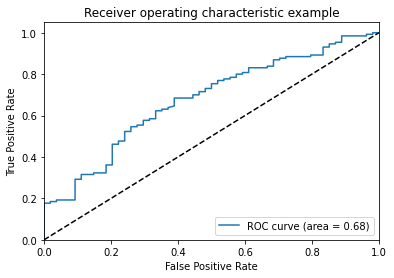

In [32]:
plt.figure()
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()